# Object Detection and Segmentation Tutorial: Part 2

# Training: Torchvision Models

In the [first part](https://github.com/LilitYolyan/object_detection_tutorial/blob/main/Part_1_Detection_Segmentation_Tutorial.ipynb)  of the tutorial we checked how to use torchvision object detection models for inference. 

Now let's find out how to train and finetune models.

Moreover, we are going to use a custom dataset to see the whole process of preparing custom dataset for training.

In [1]:
import requests
from io import BytesIO
from PIL import Image

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import os

For training we need our own dataset. Thus, we can use an open dataset that includes raccoon images. The dataset includes 200 raccoon images, we only have one class and annotations in PASCAL VOC format. Let's open a random image from the dataset:

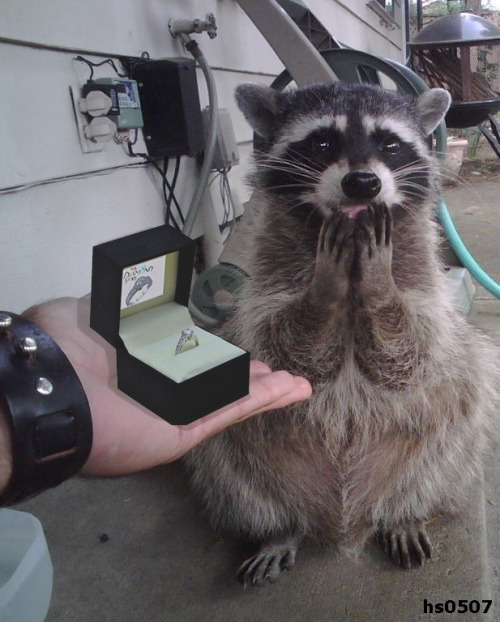

In [2]:
response = requests.get('https://github.com/experiencor/raccoon_dataset/blob/master/images/raccoon-107.jpg?raw=true')
img = Image.open(BytesIO(response.content))
img

Of course, this is not a random image. I choose this because it's cool!

Next, we need to download images for training. You can download manually or clone the GitHub repository.

In [3]:
!git clone https://github.com/experiencor/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 4.02 MiB/s, done.
Resolving deltas: 100% (412/412), done.


We now have a dataset in the same working directory where our notebook is running. Let's visualise annotations of the image above. 

The PASCAL VOC format implies that we have .xml files that contain all the information about the image. In this case we can see folder name, file name, path to the image, width, height and depth of the image and all objects in the image. 

For this particular case, we only have one object, but we can have multiple objects. The file contains information about each object's category and the bounding box.

In [4]:
with open('./raccoon_dataset/annotations/raccoon-107.xml') as annot_file:
    print(''.join(annot_file.readlines()))

<annotation verified="yes">
	<folder>images</folder>
	<filename>raccoon-107.jpg</filename>
	<path>/Users/datitran/Desktop/raccoon/images/raccoon-107.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>500</width>
		<height>622</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>raccoon</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>165</xmin>
			<ymin>51</ymin>
			<xmax>496</xmax>
			<ymax>590</ymax>
		</bndbox>
	</object>
</annotation>



The following code will extract the information needed to locate the object, in this case the bounding boxes.

In [5]:
import xml.etree.ElementTree as ET

tree = ET.parse('./raccoon_dataset/annotations/raccoon-107.xml')
root = tree.getroot()

sample_annotations = []

for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)
    

    sample_annotations.append([xmin, ymin, xmax, ymax])
    
print(sample_annotations)

[[165, 51, 496, 590]]


Now let's start preparing and training the object detection model.

First we need to define Dataset class. This class should return an image and information about that image.

In [6]:
class RaccoonDataset(torch.utils.data.Dataset):
    def __init__(self,  transforms):
        self.root =  "./raccoon_dataset"
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(self.root, "annotations"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []

        for neighbor in root.iter('bndbox'):
            xmin = int(neighbor.find('xmin').text)
            ymin = int(neighbor.find('ymin').text)
            xmax = int(neighbor.find('xmax').text)
            ymax = int(neighbor.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
        
        num_objs = len(boxes)
        

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

The next step is to prepare the model. Here we define which object detection model we are going to train and set it up for our dataset.

We will use a model pretrained on COCO dataset. 

### 1. Finetuning from a pretrained model. 

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 2. Modifying the model to add a different backbone

In [8]:
# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator)


Torch hes some helper functions that need to be installed separately. We are going to clone files from the pytorch vision repository, which we will then use to reduce codding. For example, instead of writing a training loop, we can use a loop from this repo called * train_one_epoch *

In [ ]:
%%bash

git clone https://github.com/pytorch/vision.git
cd ./vision
pwd
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [ ]:
# Import new files
import transforms as T
import utils
from engine import train_one_epoch, evaluate

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Next, we need to define dataloader which will use our Dataset object to generate batches.

In [ ]:
dataset = RaccoonDataset(get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)


Let's generate one training and inference example

In [ ]:
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   
print(output)

In [ ]:
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           
print(predictions)

This last piece of code bundles everything you need into one function. We can start training by runing *main()*.

In [ ]:
def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = RaccoonDataset(get_transform(train=True))
    dataset_test = RaccoonDataset(get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [ ]:
# To start staining run last function
# main()